<a href="https://colab.research.google.com/github/RifatAhmed1/Machine-Learning-Projects/blob/master/Transfer_learning_using_pretrained_models_and_their_comparison_on_a_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project aims to utilize transfer learning using the pre-trained models (ResNet50, VGG19, Inception_V3, and EfficientNetB7) and measure various performance metrics (precision, recall, f1-score, and accuracy) on a customized tomato leaf disease dataset.

Import necessary packages

In [ ]:
#@title
import os, os, shutil, pathlib
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, RandomRotation, RandomZoom, Rescaling, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import image_dataset_from_directory, plot_model, to_categorical

from keras.applications import resnet50
from keras.applications import vgg19
from keras.applications import inception_v3
from keras.applications import EfficientNetB7
from keras.applications import efficientnet

from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score, roc_curve, confusion_matrix

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import pandas as pd
import seaborn as sns
#%matplotlib inline

Download parent dataset from kaggle and build dataset from parent dataset

In [ ]:
# @title
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset
!unzip -qq new-plant-diseases-dataset.zip

%rm new-plant-diseases-dataset.zip
%rm -rf new\ plant\ diseases\ dataset\(augmented\)

%cd /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train

%rm -rf Apple___Apple_scab
%rm -rf Apple___Black_rot
%rm -rf Apple___Cedar_apple_rust
%rm -rf Apple___healthy
%rm -rf Blueberry___healthy
%rm -rf Cherry_\(including_sour\)___Powdery_mildew
%rm -rf Cherry_\(including_sour\)___healthy
%rm -rf Grape___Black_rot
%rm -rf Grape___Esca_\(Black_Measles\)
%rm -rf Grape___Leaf_blight_\(Isariopsis_Leaf_Spot\)
%rm -rf Grape___healthy
%rm -rf Orange___Haunglongbing_\(Citrus_greening\)
%rm -rf Peach___Bacterial_spot
%rm -rf Peach___healthy
%rm -rf Pepper,_bell___Bacterial_spot
%rm -rf Pepper,_bell___healthy
%rm -rf Raspberry___healthy
%rm -rf Soybean___healthy
%rm -rf Squash___Powdery_mildew
%rm -rf Strawberry___Leaf_scorch
%rm -rf Strawberry___healthy
%rm -rf Potato___Early_blight
%rm -rf Potato___Late_blight
%rm -rf Potato___healthy
%rm -rf Corn_\(maize\)___Cercospora_leaf_spot\ Gray_leaf_spot
%rm -rf Corn_\(maize\)___Common_rust_
%rm -rf Corn_\(maize\)___Northern_Leaf_Blight
%rm -rf Corn_\(maize\)___healthy

%cd /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid

%rm -rf Apple___Apple_scab
%rm -rf Apple___Black_rot
%rm -rf Apple___Cedar_apple_rust
%rm -rf Apple___healthy
%rm -rf Blueberry___healthy
%rm -rf Cherry_\(including_sour\)___Powdery_mildew
%rm -rf Cherry_\(including_sour\)___healthy
%rm -rf Grape___Black_rot
%rm -rf Grape___Esca_\(Black_Measles\)
%rm -rf Grape___Leaf_blight_\(Isariopsis_Leaf_Spot\)
%rm -rf Grape___healthy
%rm -rf Orange___Haunglongbing_\(Citrus_greening\)
%rm -rf Peach___Bacterial_spot
%rm -rf Peach___healthy
%rm -rf Pepper,_bell___Bacterial_spot
%rm -rf Pepper,_bell___healthy
%rm -rf Raspberry___healthy
%rm -rf Soybean___healthy
%rm -rf Squash___Powdery_mildew
%rm -rf Strawberry___Leaf_scorch
%rm -rf Strawberry___healthy
%rm -rf Potato___Early_blight
%rm -rf Potato___Late_blight
%rm -rf Potato___healthy
%rm -rf Corn_\(maize\)___Cercospora_leaf_spot\ Gray_leaf_spot
%rm -rf Corn_\(maize\)___Common_rust_
%rm -rf Corn_\(maize\)___Northern_Leaf_Blight
%rm -rf Corn_\(maize\)___healthy

%cd /content

base_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

fldrs = os.listdir(base_dir + "/train")
#print(fldrs)
for fld in fldrs:
  source_folder = base_dir + "/valid/" + fld
  destination_folder = base_dir + "/train/" + fld

  # fetch all files
  f = os.listdir(source_folder)
  #print(f)
  for file_name in f:
      # construct full file path
      source = source_folder +"/"+ file_name
      destination = destination_folder +"/"+ file_name
      # move only files
      if os.path.isfile(source):
          shutil.move(source, destination)
          #print('Moved:', file_name)

for f in os.listdir("/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"):
  os.makedirs("/content/dataset/train/"+f)
  os.makedirs("/content/dataset/valid/"+f)
  os.makedirs("/content/dataset/test/"+f)

base_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"

for f in os.listdir(base_dir):
  src_fldr = base_dir + "/" + f
  dst_fldr = "/content/dataset/train/"+f

  file_list = os.listdir(src_fldr)
  file_list = [f for f in file_list if os.path.isfile(os.path.join(src_fldr, f))]

  for file_name in file_list[:1272]:
    source_file_path = os.path.join(src_fldr, file_name)
    destination_file_path = os.path.join(dst_fldr, file_name)
    shutil.copy2(source_file_path, destination_file_path)

for f in os.listdir(base_dir):
  src_fldr = base_dir + "/" + f
  dst_fldr = "/content/dataset/valid/"+f

  file_list = os.listdir(src_fldr)
  file_list = [f for f in file_list if os.path.isfile(os.path.join(src_fldr, f))]

  for file_name in file_list[1272:1696]:
    source_file_path = os.path.join(src_fldr, file_name)
    destination_file_path = os.path.join(dst_fldr, file_name)
    shutil.copy2(source_file_path, destination_file_path)

for f in os.listdir(base_dir):
  src_fldr = base_dir + "/" + f
  dst_fldr = "/content/dataset/test/"+f

  file_list = os.listdir(src_fldr)
  file_list = [f for f in file_list if os.path.isfile(os.path.join(src_fldr, f))]

  for file_name in file_list[1696:2120]:
    source_file_path = os.path.join(src_fldr, file_name)
    destination_file_path = os.path.join(dst_fldr, file_name)
    shutil.copy2(source_file_path, destination_file_path)

Saving kaggle.json to kaggle.json
100% 2.70G/2.70G [02:09<00:00, 23.3MB/s]
100% 2.70G/2.70G [02:09<00:00, 22.3MB/s]
/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid
/content


Split the dataset into train, validation and test sets

In [ ]:
# @title
# Define image data directories
base_dir = pathlib.Path("/content/dataset")
train_data_dir = base_dir / 'train'
val_data_dir = base_dir / 'valid'
test_data_dir = base_dir / 'test'

batch_size = 32
input_shape = (180, 180, 3)  # Modify according to your image size and channels
num_classes = 10  # Modify based on your task

# Load and preprocess the dataset using image_dataset_from_directory
train_dataset = image_dataset_from_directory(
    train_data_dir,
    image_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    shuffle=True
)

val_dataset = image_dataset_from_directory(
    val_data_dir,
    image_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    shuffle=False
)

test_dataset = image_dataset_from_directory(
    test_data_dir,
    image_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    shuffle=False
)

Found 12720 files belonging to 10 classes.
Found 4240 files belonging to 10 classes.
Found 4240 files belonging to 10 classes.


Download and initialize the pre-trained models

In [ ]:
rn50_model = resnet50.ResNet50(
    input_shape=(180,180,3),
    weights='imagenet',
    include_top=False)

#rn50_model.summary()

v19_model = vgg19.VGG19(
    input_shape=(180,180,3),
    weights='imagenet',
    include_top=False)

#v19_model.summary()

incep_v3_model = inception_v3.InceptionV3(
    input_shape=(180,180,3),
    weights='imagenet',
    include_top=False)

#incep_v3_model.summary()

effnetb7_model = EfficientNetB7(
    input_shape=(180,180,3),
    weights='imagenet',
    include_top=False)

#effnetb7_model.summary()

rn50_model.trainable = False
v19_model.trainable = False
incep_v3_model.trainable = False
effnetb7_model.trainable = False

258076736/258076736 [==============================] - 12s 0us/step


Create necessary functions

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)

def create_history(model_name):
  history = model_name.fit(
      train_dataset,
      validation_data=val_dataset,
      callbacks=[early_stopping],
      epochs=50)
  return history

def plotter(base_model_1_history):
  accuracy = base_model_1_history.history["accuracy"]
  val_accuracy = base_model_1_history.history["val_accuracy"]
  loss = base_model_1_history.history["loss"]
  val_loss = base_model_1_history.history["val_loss"]
  epochs = range(1, len(accuracy) + 1)
  plt.plot(epochs, accuracy, "o:r", label="Training accuracy")
  plt.plot(epochs, val_accuracy, "o:b", label="Validation accuracy")
  plt.title("Training and validation accuracy")
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, "o:r", label="Training loss")
  plt.plot(epochs, val_loss, "o:b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.legend()
  plt.show()

def save_and_plot(file_name, model):
  model_history = create_history(model)
  model.save(file_name)
  plotter(model_history)

def result(model_name):
  test_model = keras.models.load_model(model_name)
  test_loss, test_acc = test_model.evaluate(test_dataset)
  print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
def get_labels(dataset):
  all_labels = []
  for images, labels in dataset:
    all_labels.append(labels)
  return np.concatenate(all_labels)

test_labels = get_labels(test_dataset)
num_classes = 10

def metrices_plotter(model_name):
  test_model = keras.models.load_model(model_name)
  prediction = test_model.predict(test_dataset)
  max_class_indices = np.argmax(prediction, axis = 1)
  max_probabilites = np.max(prediction, axis=1)

  one_hot_test_labels = to_categorical(test_labels, num_classes=num_classes)
  one_hot_pred_labels = to_categorical(max_class_indices, num_classes=num_classes)

  precision = dict()
  recall = dict()

  for class_idx in range(10):
    precision[class_idx], recall[class_idx], _ = precision_recall_curve(
        one_hot_test_labels[:,class_idx], one_hot_pred_labels[:,class_idx]
    )

  #precision and recall score
  accuracy = accuracy_score(one_hot_test_labels, one_hot_pred_labels)
  print('Accuracy: %f' % accuracy)
  print('\n')

  # precision tp / (tp + fp)
  precision = precision_score(one_hot_test_labels, one_hot_pred_labels, average=None)
  print('precision of classes 0 to 9')
  for i in range(10):
    print('%f' %(precision[i]) )
  print('\n')

  # recall: tp / (tp + fn)
  recall = recall_score(one_hot_test_labels, one_hot_pred_labels, average=None)
  print('recall of classes 0 to 9')
  for i in range(10):
    print('%f' %(recall[i]) )
  print('\n')

  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(one_hot_test_labels, one_hot_pred_labels, average=None)
  print('f1_score of classes 0 to 9')
  for i in range(10):
    print('%f' %(f1[i]) )
  print('\n')

  x_axis = ['0','1','2','3','4','5','6','7','8','9', ]
  y_axis = precision

  plt.figure(figsize=(10,4))
  plt.rc('axes', axisbelow=True)
  plt.grid(zorder=0)

  plt.bar(x_axis, y_axis, width=0.4, color='b')
  plt.title('Precision')
  plt.xlabel('Class')
  plt.ylabel('Precision Value')
  plt.show()

  y_axis = recall
  plt.figure(figsize=(10,4))
  plt.rc('axes', axisbelow=True)
  plt.grid(zorder=0)
  plt.bar(x_axis, y_axis, width=0.4, color='g')
  plt.title('Recall')
  plt.xlabel('Class')
  plt.ylabel('Recall Value')
  plt.show()

  y_axis = f1
  plt.figure(figsize=(10,4))
  plt.rc('axes', axisbelow=True)
  plt.grid(zorder=0)
  plt.bar(x_axis, y_axis, width=0.4, color='r')
  plt.title('F1-Score')
  plt.xlabel('Class')
  plt.ylabel('F1-Score Value')
  plt.show()

# precision-recall
  plt.figure()
  precision_ = dict()
  recall_ = dict()
  for i in range(num_classes):
      precision_[i], recall_[i], _ = precision_recall_curve(one_hot_test_labels[:, i],
                                    one_hot_pred_labels[:, i])
      plt.plot(recall_[i], precision_[i], lw=2,marker='.',label=f'Class {i}')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curves (Multiclass)')
  plt.legend()
  plt.show()
# roc
  plt.figure()
  fpr = dict()
  tpr = dict()

  for i in range(10):
      fpr[i], tpr[i], _ = roc_curve(one_hot_test_labels[:, i],
                                    one_hot_pred_labels[:, i])
      plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

  plt.xlabel("false positive rate")
  plt.ylabel("true positive rate")
  plt.legend(loc="best")
  plt.title("ROC curve")
  plt.show()

In [ ]:
inputs = keras.Input(shape=(180,180,3))

ResNet50

In [ ]:
x1 = resnet50.preprocess_input(inputs)
x1 = rn50_model(x1)
x1 = Flatten()(x1)
outputs1 = Dense(10, activation='softmax')(x1)

x1_model = Model(inputs,outputs1)
x1_model.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])


Epoch 1/50
398/398 [==============================] - 50s 97ms/step - loss: 2.0340 - accuracy: 0.8429 - val_loss: 1.6487 - val_accuracy: 0.8955
Epoch 2/50
398/398 [==============================] - 37s 92ms/step - loss: 0.5297 - accuracy: 0.9557 - val_loss: 1.7007 - val_accuracy: 0.9167
Epoch 3/50
398/398 [==============================] - 38s 95ms/step - loss: 0.3996 - accuracy: 0.9675 - val_loss: 1.1432 - val_accuracy: 0.9363
Epoch 4/50
398/398 [==============================] - 38s 94ms/step - loss: 0.3069 - accuracy: 0.9756 - val_loss: 1.2699 - val_accuracy: 0.9401
Epoch 5/50
398/398 [==============================] - 38s 94ms/step - loss: 0.2393 - accuracy: 0.9808 - val_loss: 2.4233 - val_accuracy: 0.9101
Epoch 6/50
398/398 [==============================] - 39s 97ms/step - loss: 0.3491 - accuracy: 0.9782 - val_loss: 1.5444 - val_accuracy: 0.9483
Epoch 7/50
398/398 [==============================] - 38s 95ms/step - loss: 0.2252 - accuracy: 0.9869 - val_loss: 1.3237 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


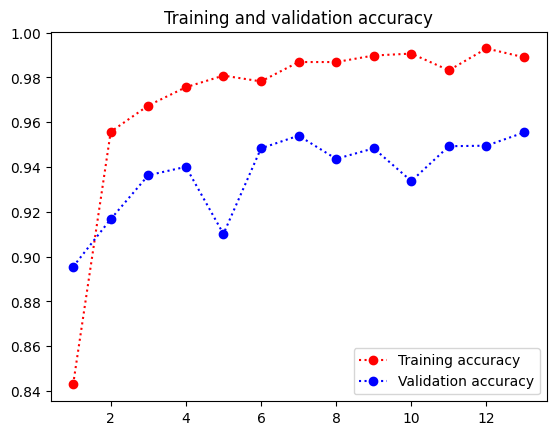

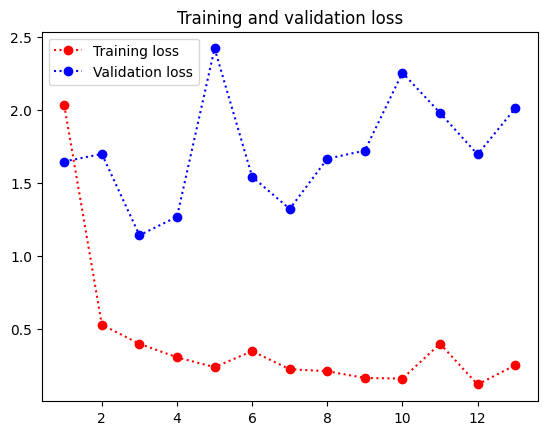

In [ ]:
file_name_1 = 'rn50_model.h5'
save_and_plot(file_name_1, x1_model)

In [ ]:
result(file_name_1)

133/133 [==============================] - 11s 72ms/step - loss: 1.3578 - accuracy: 0.9295
Test accuracy: 0.929


133/133 [==============================] - 10s 70ms/step
Accuracy: 0.929481


precision of classes 0 to 9
0.960465
0.971429
0.914221
0.976378
0.819085
0.908257
0.924084
0.912473
0.978873
0.962963


recall of classes 0 to 9
0.974057
0.801887
0.955189
0.877358
0.971698
0.933962
0.832547
0.983491
0.983491
0.981132


f1_score of classes 0 to 9
0.967213
0.878553
0.934256
0.924224
0.888889
0.920930
0.875931
0.946652
0.981176
0.971963




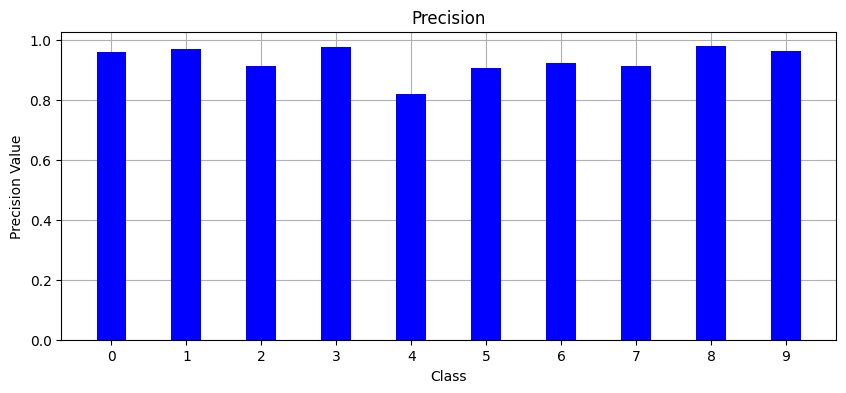

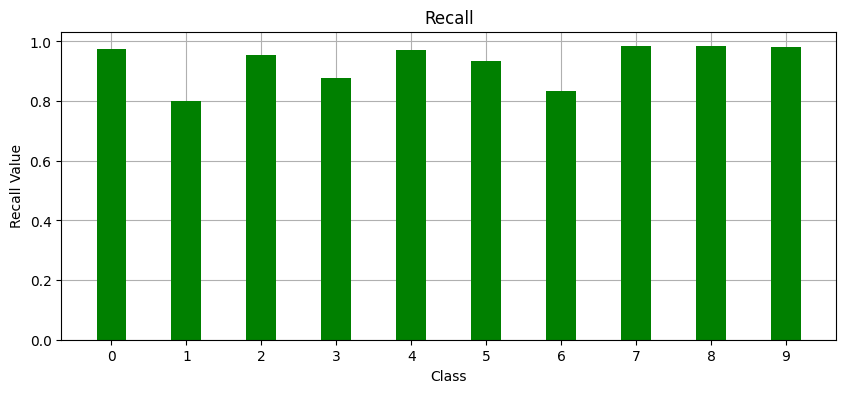

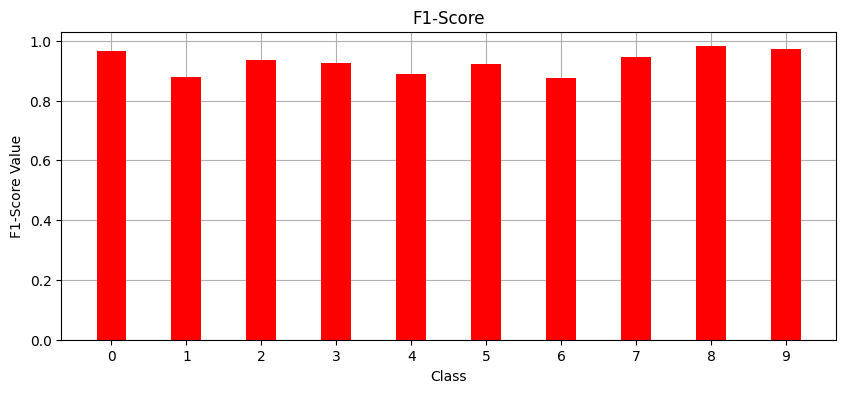

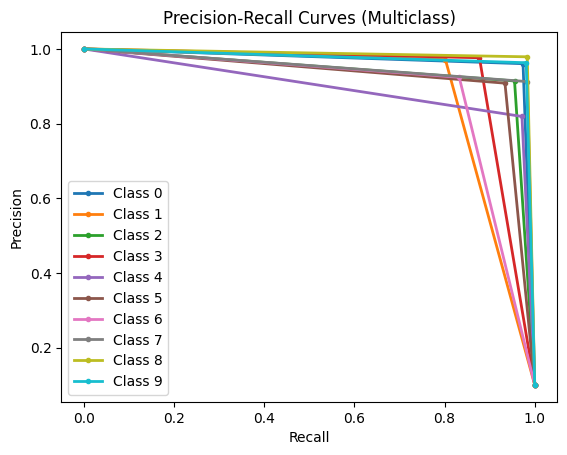

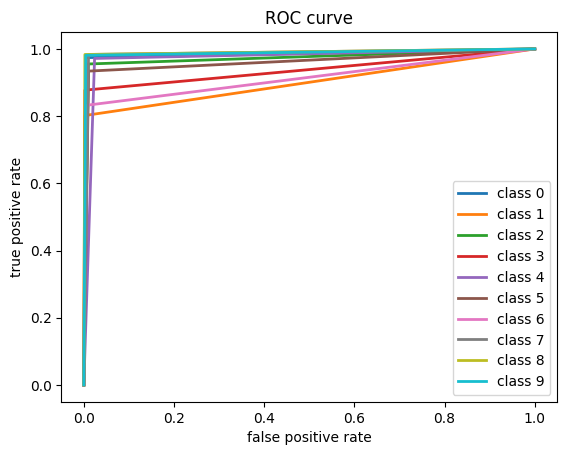

In [ ]:
metrices_plotter(file_name_1)

VGG19



In [ ]:
x2 = vgg19.preprocess_input(inputs)
x2 = v19_model(x2)
x2 = Flatten()(x2)
outputs2 = Dense(10, activation='softmax')(x2)

x2_model = Model(inputs,outputs2)
x2_model.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

Epoch 1/50
398/398 [==============================] - 61s 146ms/step - loss: 2.8947 - accuracy: 0.7657 - val_loss: 1.6337 - val_accuracy: 0.8738
Epoch 2/50
398/398 [==============================] - 56s 141ms/step - loss: 0.7999 - accuracy: 0.9245 - val_loss: 1.9132 - val_accuracy: 0.8639
Epoch 3/50
398/398 [==============================] - 56s 141ms/step - loss: 0.4451 - accuracy: 0.9524 - val_loss: 2.2520 - val_accuracy: 0.8606
Epoch 4/50
398/398 [==============================] - 56s 141ms/step - loss: 0.3351 - accuracy: 0.9659 - val_loss: 2.0250 - val_accuracy: 0.8790
Epoch 5/50
398/398 [==============================] - 56s 141ms/step - loss: 0.3740 - accuracy: 0.9638 - val_loss: 2.1798 - val_accuracy: 0.8901
Epoch 6/50
398/398 [==============================] - 63s 158ms/step - loss: 0.3509 - accuracy: 0.9676 - val_loss: 2.7497 - val_accuracy: 0.8800
Epoch 7/50
398/398 [==============================] - 57s 142ms/step - loss: 0.4302 - accuracy: 0.9641 - val_loss: 2.8261 - val_ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


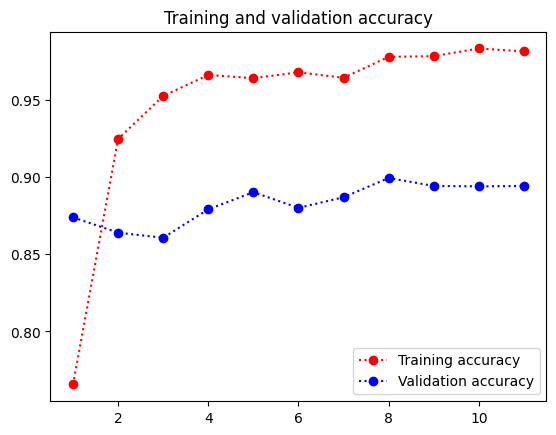

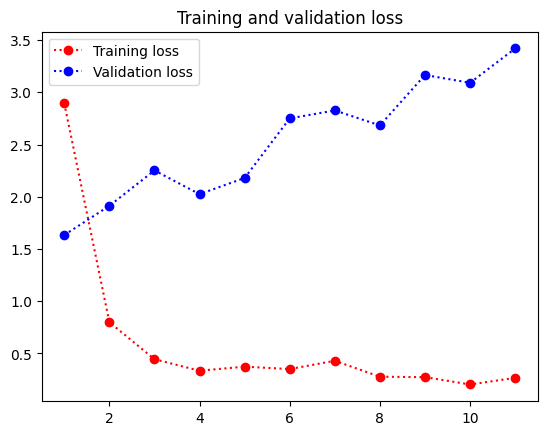

In [ ]:
file_name_2 = 'v19_model.h5'
save_and_plot(file_name_2, x2_model)

In [ ]:
result(file_name_2)

133/133 [==============================] - 14s 106ms/step - loss: 1.8660 - accuracy: 0.8594
Test accuracy: 0.859


133/133 [==============================] - 14s 103ms/step
Accuracy: 0.859434


precision of classes 0 to 9
0.896313
0.793187
0.815846
0.843891
0.811189
0.868557
0.766990
0.989848
0.914352
0.902552


recall of classes 0 to 9
0.917453
0.768868
0.898585
0.879717
0.820755
0.794811
0.745283
0.919811
0.931604
0.917453


f1_score of classes 0 to 9
0.906760
0.780838
0.855219
0.861432
0.815944
0.830049
0.755981
0.953545
0.922897
0.909942




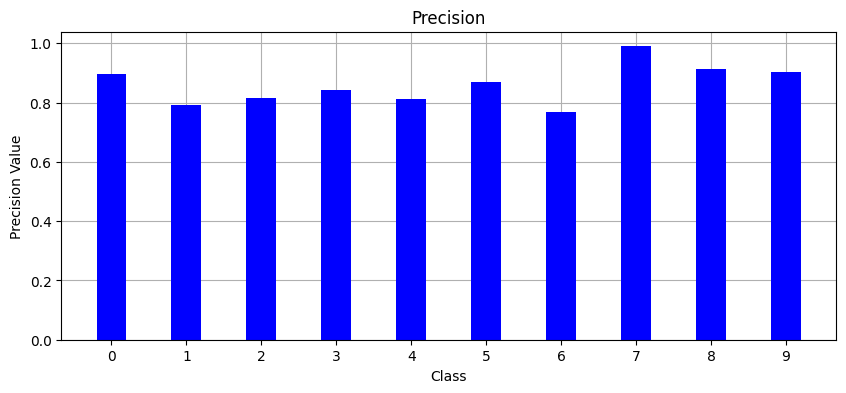

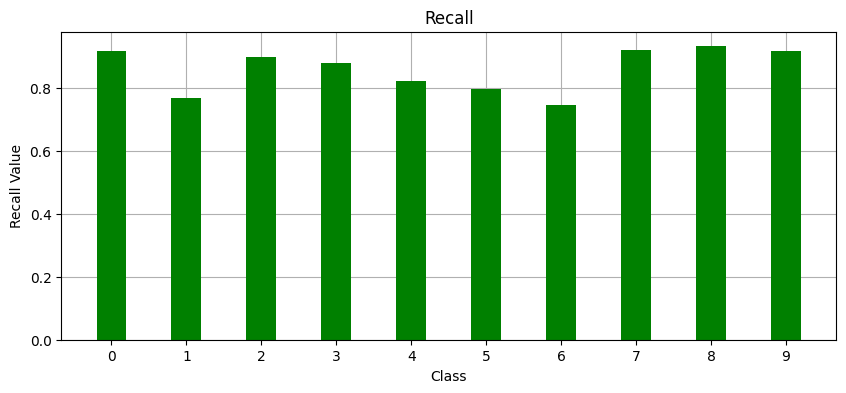

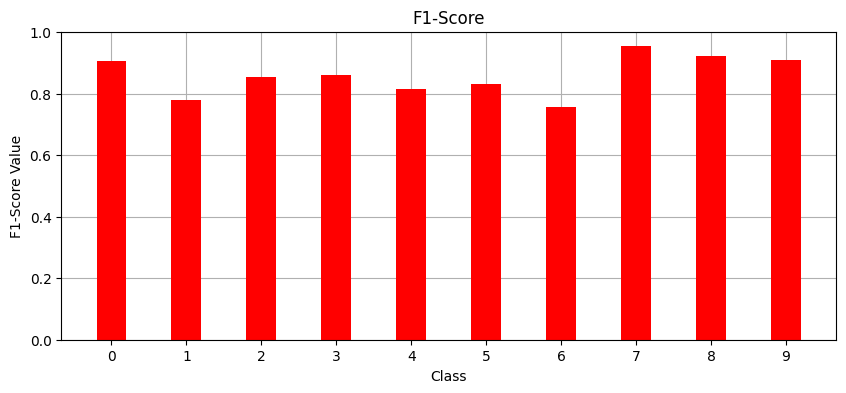

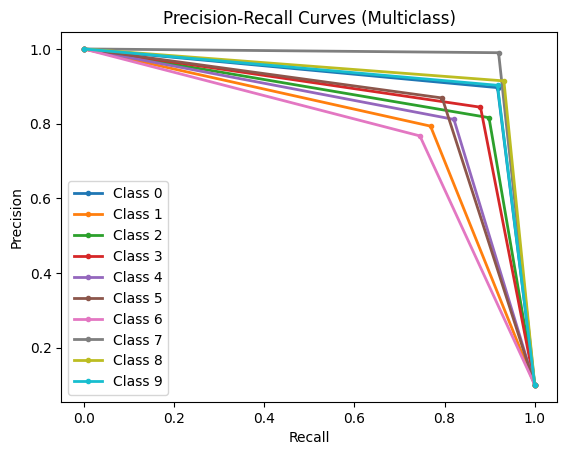

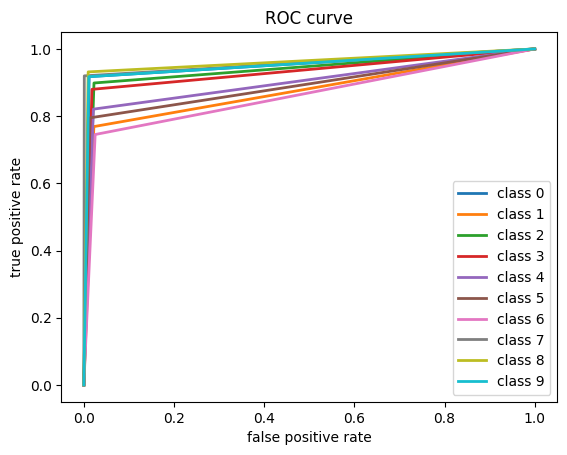

In [ ]:
metrices_plotter(file_name_2)

Inception_V3

In [ ]:
x3 = inception_v3.preprocess_input(inputs)
x3 = incep_v3_model(x3)
x3 = Flatten()(x3)
outputs3 = Dense(10, activation='softmax')(x3)

x3_model = Model(inputs,outputs3)
x3_model.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

Epoch 1/50
398/398 [==============================] - 36s 75ms/step - loss: 2.3149 - accuracy: 0.6798 - val_loss: 2.8193 - val_accuracy: 0.7127
Epoch 2/50
398/398 [==============================] - 27s 67ms/step - loss: 1.0907 - accuracy: 0.8339 - val_loss: 2.4913 - val_accuracy: 0.7366
Epoch 3/50
398/398 [==============================] - 27s 67ms/step - loss: 0.7689 - accuracy: 0.8825 - val_loss: 1.3045 - val_accuracy: 0.8380
Epoch 4/50
398/398 [==============================] - 28s 69ms/step - loss: 0.6074 - accuracy: 0.9073 - val_loss: 2.0402 - val_accuracy: 0.8139
Epoch 5/50
398/398 [==============================] - 27s 68ms/step - loss: 0.4816 - accuracy: 0.9261 - val_loss: 2.1813 - val_accuracy: 0.8144
Epoch 6/50
398/398 [==============================] - 27s 67ms/step - loss: 0.6074 - accuracy: 0.9215 - val_loss: 2.0379 - val_accuracy: 0.8356
Epoch 7/50
398/398 [==============================] - 27s 68ms/step - loss: 0.3577 - accuracy: 0.9481 - val_loss: 2.5771 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


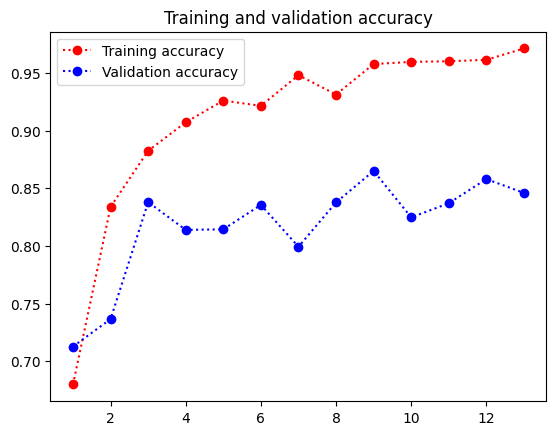

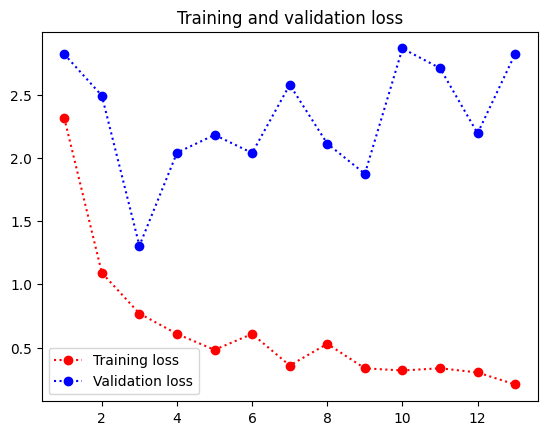

In [ ]:
file_name_3 = 'incep_v3_model.h5'
save_and_plot(file_name_3, x3_model)

In [ ]:
result(file_name_3)

133/133 [==============================] - 9s 57ms/step - loss: 1.4656 - accuracy: 0.8226
Test accuracy: 0.823


133/133 [==============================] - 8s 55ms/step
Accuracy: 0.822642


precision of classes 0 to 9
0.902500
0.833333
0.828502
0.881215
0.567208
0.849010
0.770619
0.925339
0.976879
0.875269


recall of classes 0 to 9
0.851415
0.672170
0.808962
0.752358
0.905660
0.808962
0.705189
0.964623
0.797170
0.959906


f1_score of classes 0 to 9
0.876214
0.744125
0.818616
0.811705
0.697548
0.828502
0.736453
0.944573
0.877922
0.915636




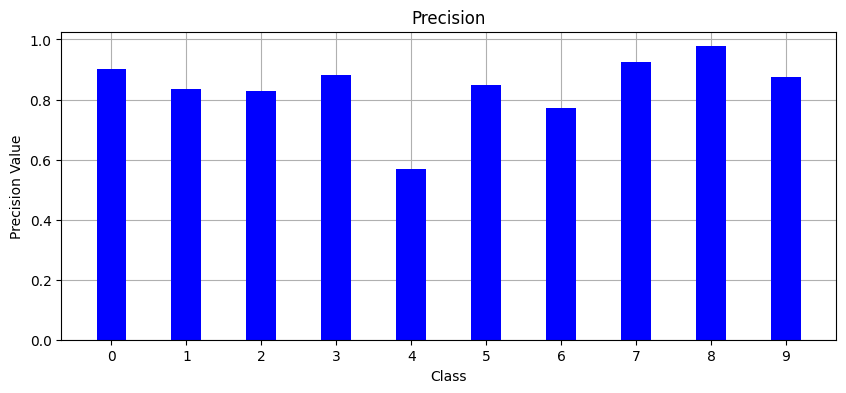

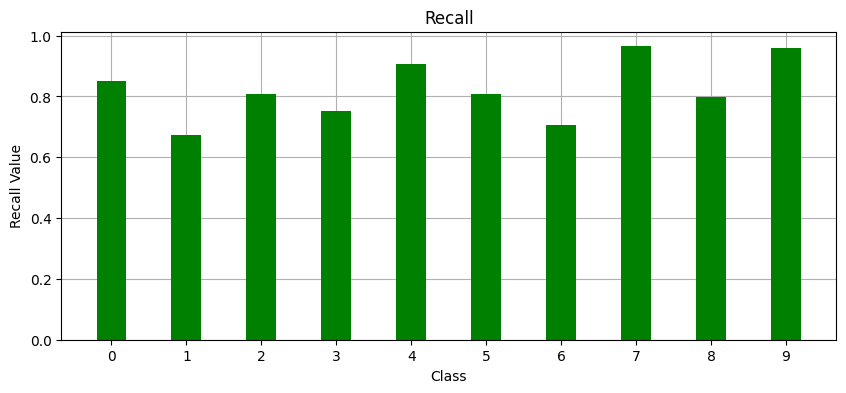

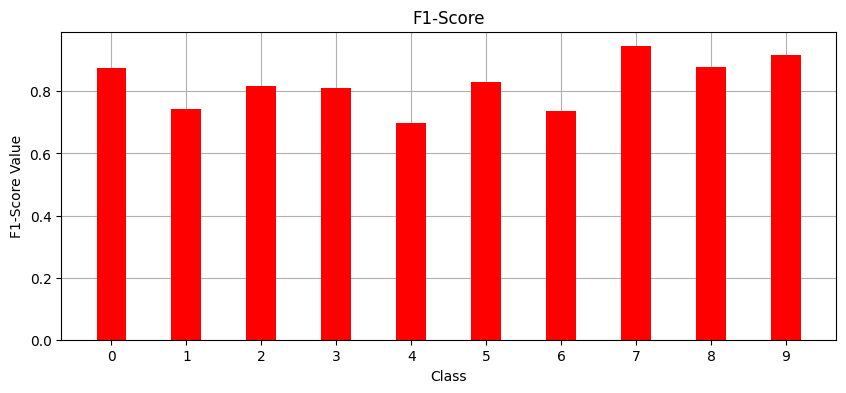

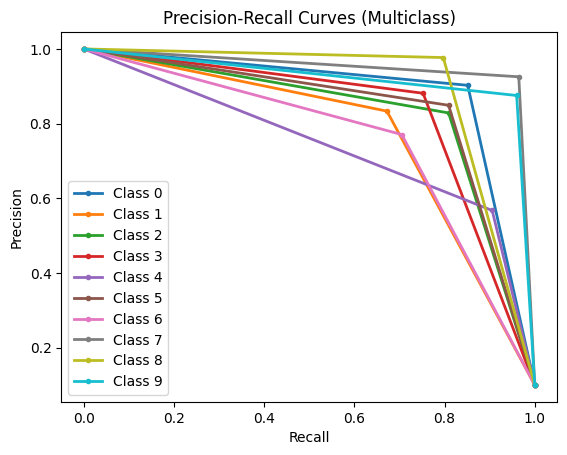

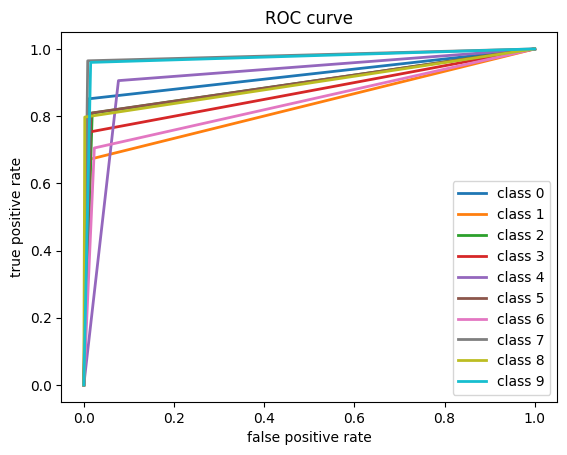

In [ ]:
metrices_plotter(file_name_3)

EfficientNetB7

In [ ]:
x4 = efficientnet.preprocess_input(inputs)
x4 = effnetb7_model(x4)
x4 = Flatten()(x4)
outputs4 = Dense(10, activation='softmax')(x4)

x4_model = Model(inputs,outputs4)
x4_model.compile(loss='sparse_categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

Epoch 1/50
398/398 [==============================] - 173s 371ms/step - loss: 2.4667 - accuracy: 0.7178 - val_loss: 1.1127 - val_accuracy: 0.8361
Epoch 2/50
398/398 [==============================] - 137s 344ms/step - loss: 1.2358 - accuracy: 0.8430 - val_loss: 1.2110 - val_accuracy: 0.8613
Epoch 3/50
398/398 [==============================] - 144s 362ms/step - loss: 0.8830 - accuracy: 0.8862 - val_loss: 0.9534 - val_accuracy: 0.8814
Epoch 4/50
398/398 [==============================] - 144s 362ms/step - loss: 0.8358 - accuracy: 0.9041 - val_loss: 1.0197 - val_accuracy: 0.8946
Epoch 5/50
398/398 [==============================] - 137s 345ms/step - loss: 0.8073 - accuracy: 0.9111 - val_loss: 1.0869 - val_accuracy: 0.9002
Epoch 6/50
398/398 [==============================] - 137s 344ms/step - loss: 0.9019 - accuracy: 0.9139 - val_loss: 1.6248 - val_accuracy: 0.8795
Epoch 7/50
398/398 [==============================] - 144s 362ms/step - loss: 0.7309 - accuracy: 0.9285 - val_loss: 1.5979 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


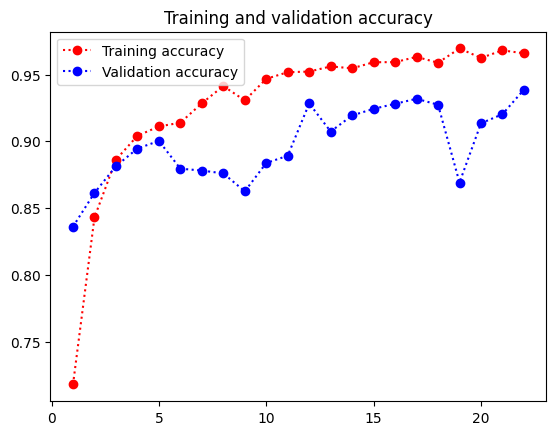

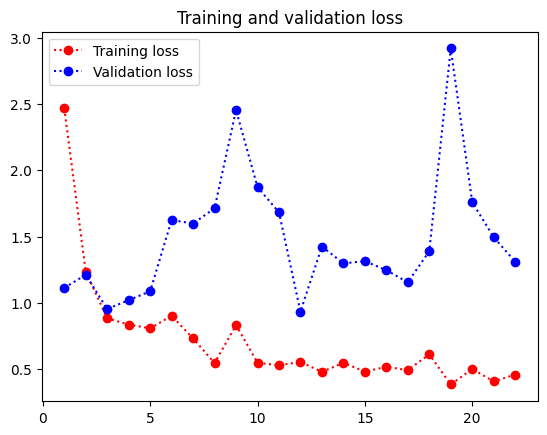

In [ ]:
file_name_4 = 'effnetb7_model.h5'
save_and_plot(file_name_4, x4_model)

In [ ]:
result(file_name_4)

133/133 [==============================] - 40s 261ms/step - loss: 1.0640 - accuracy: 0.9248
Test accuracy: 0.925


133/133 [==============================] - 40s 254ms/step
Accuracy: 0.924764


precision of classes 0 to 9
0.941995
0.962536
0.824950
0.961259
0.896471
0.942211
0.848018
0.923246
0.992754
0.990123


recall of classes 0 to 9
0.957547
0.787736
0.966981
0.936321
0.898585
0.884434
0.908019
0.992925
0.969340
0.945755


f1_score of classes 0 to 9
0.949708
0.866407
0.890337
0.948626
0.897527
0.912409
0.876993
0.956818
0.980907
0.967431




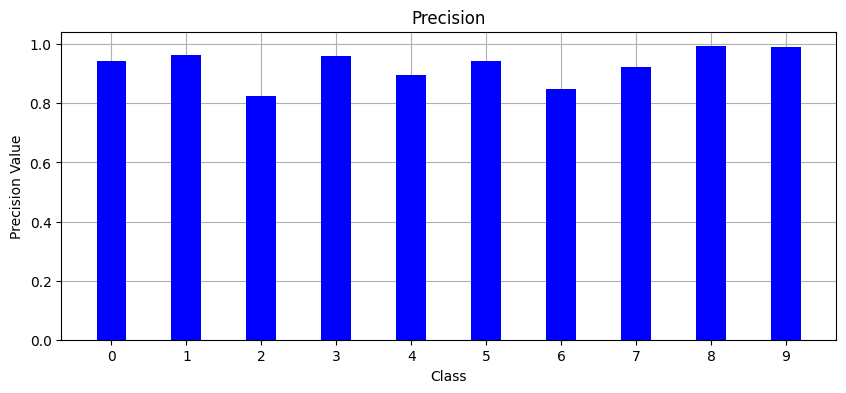

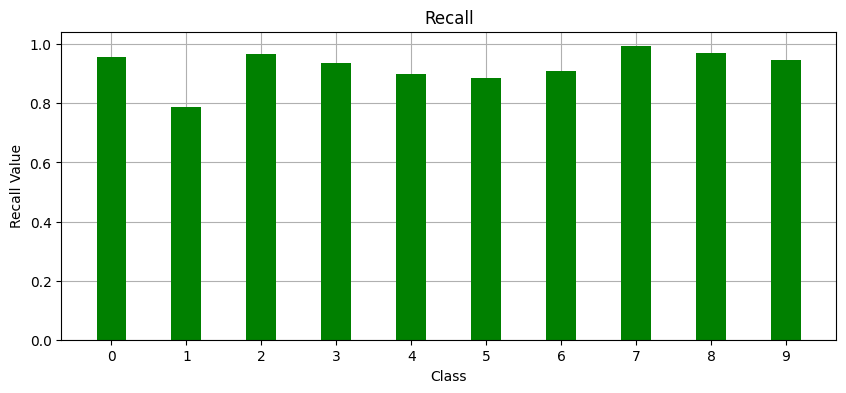

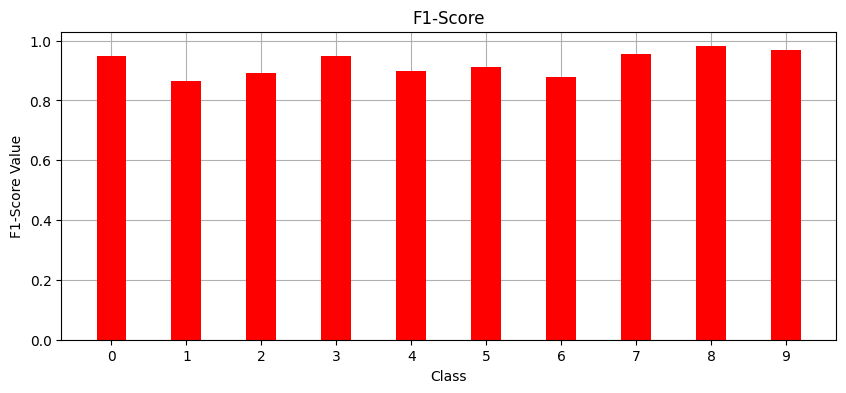

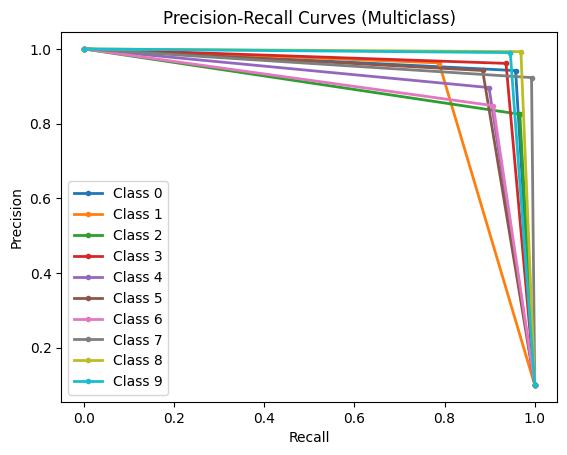

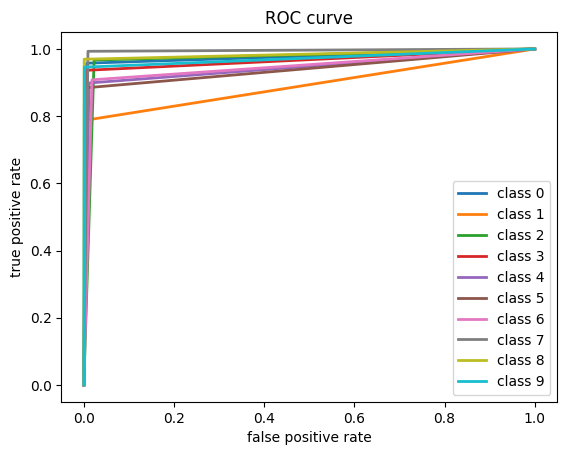

In [ ]:
metrices_plotter(file_name_4)